# load data

In [1]:
import glob
import os
import json
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb
from shutil import copyfile
from tqdm import tqdm
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment  # download from https://gist.github.com/txdat/e6583def88d95b4ded049703e2ac3cc2

In [2]:
data_dir = "../data/vin/Official"

found 94 subjects
CPU times: user 62.9 ms, sys: 17.8 ms, total: 80.7 ms
Wall time: 148 ms


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

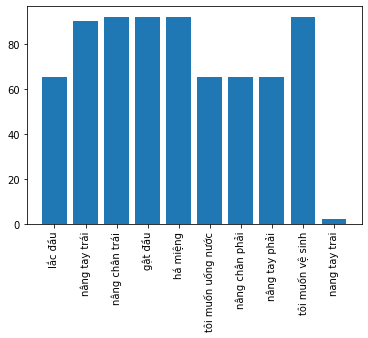

In [3]:
%%time
subjects_scenarios = load_subjects(data_dir)
print(f"found {len(subjects_scenarios)} subjects")

scenario_count = dict()
for _, scenarios in subjects_scenarios:
    for scenario in scenarios:
        if scenario in scenario_count:
            scenario_count[scenario] += 1
        else:
            scenario_count[scenario] = 1

plt.bar(scenario_count.keys(), scenario_count.values())
plt.xticks(rotation='vertical')

### EEG decoding

In [4]:
%%time
# fmt: off
# subjects = [
#     # 'K299', 'K300', 
#     'K309', 'K310', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K318', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

# subjects = [
#     'K309', 'K311', 'K312', 'K313', 'K315', 
#     'K316', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K328', 'K329', 'K337', 
#     'K338', 'K339', 'K358', 'K359', 'K360', 
#     'K361', 'K365', 'K366', 'K367', 'K368', 
#     'K369', 'K370', 'K371', 'K372', 'K375',
# ]

subjects = [
    'K309', 'K311', 'K312', 'K313', 'K315', 
    'K316', 'K320', 'K321', 'K322', 'K323', 
    'K324', 'K325', 'K326', 'K327', 'K328', 
    'K329', 'K330', 'K337', 'K339', 'K354', 
    'K355', 'K358', 'K359', 'K360', 'K361', 
    'K362', 'K365', 'K366', 'K368', 'K369', 
    'K370', 'K371', 'K372', 'K374', 'K375',
]

# use_k_subjects = True  # @param {"type": "boolean"}
# use_bn_subjects = False  # @param {"type": "boolean"}

# subjects = list()
# if use_k_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("K")])
# if use_bn_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("BN")])

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
#     "Thinking and Acting",
    "Resting",
    # "Typing",
]

# channels = [
#     "Fp1", "F7", "F3", "FC5", "FC1", "T7", "C3", "CP5", "CP1", "P7", "P3", "O1",  # left
#     "Fz", "Cz", "Pz", "Oz",  # center
#     "Fp2", "F8", "F4", "FC6", "FC2", "T8", "C4", "CP6", "CP2", "P8", "P4", "O2",  # right
# ]
channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]

label_mapping={
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
#     "nâng tay trái_Thinking": "nâng tay",
#     "nâng tay phải_Thinking": "nâng tay",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
#     "nâng chân trái_Thinking": "nâng chân",
#     "nâng chân phải_Thinking": "nâng chân",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "nâng tay trái_Thinking and Acting": "other",
    # "nâng tay phải_Thinking and Acting": "other",
    # "nâng chân trái_Thinking and Acting": "other",
    # "nâng chân phải_Thinking and Acting": "other",
    # "gật đầu_Thinking and Acting": "other",
    # "lắc đầu_Thinking and Acting": "other",
    "Resting": "other",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2  # @param
window_stride_duration = 0.2  # @param

fmin = 1.0  # @param
fmax = 40.0  # @param

ds = load_data(
    "../data/vin/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)
# fmt: on

ds_info = ds.description

using 32 channels


subject:  38%|████████████████████████████████▏                                                   | 36/94 [00:00<00:00, 211.36it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:201: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  83%|██████████████████████████████████████████████████████████████████████▌              | 78/94 [00:01<00:00, 49.87it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:201: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:201: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/txdat/code/eeg-motor-imagery/notebooks/dat

CPU times: user 26.5 s, sys: 2.88 s, total: 29.4 s
Wall time: 31.3 s


In [5]:
ds_info = ds.description
ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

ds_info.sort_values("epochs", ascending=False)

,subject,scenario,event,label,trial,split,epochs
618,K338,nâng tay trái,Resting,other,5,train,76
630,K338,nâng chân trái,Thinking,nâng chân trái,1,train,70
659,K338,lắc đầu,Thinking,lắc đầu,2,train,68
623,K338,nâng tay phải,Resting,other,2,train,66
1002,K366,lắc đầu,Resting,other,2,train,66
...,...,...,...,...,...,...,...
1291,K375,nâng tay trái,Resting,other,4,train,11
530,K328,nâng chân trái,Resting,other,5,train,11
388,K323,nâng tay trái,Resting,other,3,train,11
963,K366,nâng tay trái,Resting,other,5,train,11


In [7]:
ds_info[ds_info["trial"] == 0].groupby(["subject"]).sum().sort_values("epochs")

,trial,epochs
subject,,
K342,0,117
K322,0,119
K343,0,121
K365,0,123
K367,0,125
K332,0,129
K320,0,131
K363,0,133
K344,0,133


In [8]:
len(ds_info["subject"].unique())

60

<AxesSubplot:xlabel='subject'>

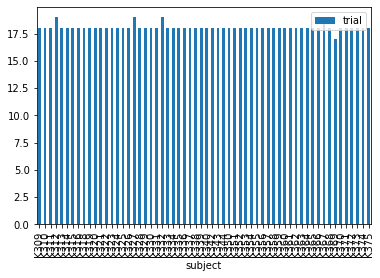

In [9]:
ds_info[["subject", "trial"]].groupby("subject").count().plot.bar()

<AxesSubplot:xlabel='scenario'>

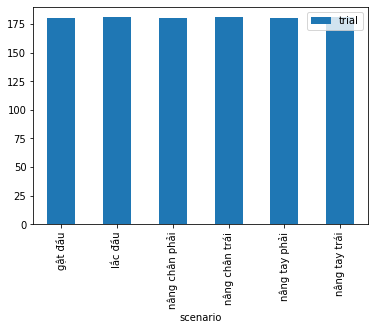

In [10]:
ds_info[["scenario", "trial"]].groupby("scenario").count().plot.bar()

<AxesSubplot:xlabel='scenario'>

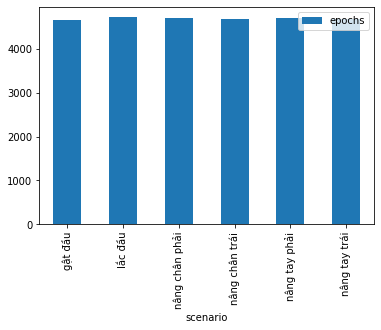

In [11]:
ds_info[["scenario", "epochs"]].groupby("scenario").sum().plot.bar()

<AxesSubplot:xlabel='trial'>

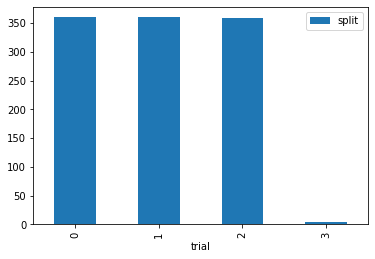

In [12]:
ds_info[["trial", "split"]].groupby("trial").count().plot.bar()

<AxesSubplot:xlabel='label'>

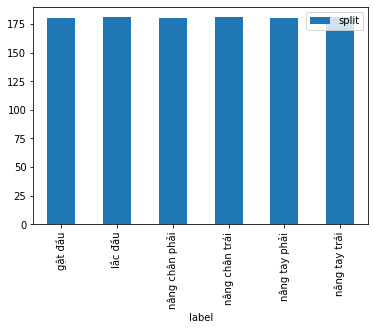

In [13]:
ds_info[["label", "split"]].groupby("label").count().plot.bar()

In [6]:
y = list()
for epochs in ds.datasets:
    y.extend(epochs.y)

print(np.bincount(np.array(y, dtype=int)))

[2324 2360 2358 2400 2404 2399]


In [6]:
from typing import Optional
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
from pytorch_metric_learning.losses import ArcFaceLoss
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, Deep4Net, EEGNetv4
from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss
from braindecode.datasets import BaseConcatDataset
from skorch.callbacks import LRScheduler, EarlyStopping, Initializer, LoadInitState, Freezer, Checkpoint, TrainEndCheckpoint
from skorch.helper import predefined_split
from skorch.setter import optimizer_setter
from skorch.dataset import unpack_data
from skorch.utils import to_tensor
from sklearn.utils.class_weight import compute_class_weight
import sklearn.metrics as metrics
from functools import partial
from copy import deepcopy
from tqdm import tqdm
import time
from datetime import timedelta

from eadam import EAdam  # download from https://github.com/yuanwei2019/EAdam-optimizer/blob/main/EAdam.py

In [7]:
print(torch.cuda.is_available())

device = torch.device("cuda")

seed = 42  # @param
set_random_seeds(seed=42, cuda=True, cudnn_benchmark=False)  # reproduce result

True


In [8]:
def init_weights(self):
    for m in self.modules():
        if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
            # nn.init.xavier_uniform_(m.weight, gain=1.0)
            nn.init.kaiming_uniform_(m.weight, nonlinearity="leaky_relu")

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

In [9]:
class Square(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * x


class SafeLog(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()

        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.log(torch.clamp(x, min=self.eps))


class Covariance(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [bsz, *, ch, t]
        return torch.matmul(x, x.transpose(-2, -1)) / (x.size(-1) - 1)


class ConstraintConv2d(nn.Conv2d):
    def __init__(self, *args, maxnorm=1.0, **kwargs):
        super().__init__(*args, **kwargs)

        self.maxnorm = maxnorm

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.maxnorm
        )

        return super().forward(x)


class Conv2d(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        *args,
        use_constraint_conv=False,
        use_sep_conv=False,
        use_norm=False,
        use_act=False,
        **kwargs
    ):
        super().__init__()

        conv_class = [nn.Conv2d, ConstraintConv2d][int(use_constraint_conv)]

        if use_sep_conv:
            kwargs.pop("groups", None)
            self.add_module(
                "dw_conv",
                conv_class(
                    in_channels, in_channels, *args, groups=in_channels, **kwargs
                ),
            )

            if use_norm:
                self.add_module("dw_norm", nn.BatchNorm2d(in_channels))

            for k in ["kernel_size", "stride", "padding", "bias"]:
                kwargs.pop(k, None)
            self.add_module(
                "pw_conv",
                conv_class(
                    in_channels,
                    out_channels,
                    kernel_size=(1, 1),
                    stride=(1, 1),
                    padding=(0, 0),
                    groups=1,
                    bias=False,
                    **kwargs,
                ),
            )

            if use_norm:
                self.add_module("pw_norm", nn.BatchNorm2d(out_channels))

        else:
            self.add_module(
                "conv", conv_class(in_channels, out_channels, *args, **kwargs)
            )

            if use_norm:
                self.add_module("norm", nn.BatchNorm2d(out_channels))

        if use_act:
            self.add_module("act", nn.ELU(inplace=True))


def drop_path(
    x, drop_prob: float = 0.0, training: bool = False, scale_by_keep: bool = True
):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0.0 or not training:
        return x

    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (
        x.ndim - 1
    )  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob: float = 0.0, scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


class SqueezeExcite(nn.Module):
    def __init__(self):
        super().__init__()


In [10]:
class SymmetricSpatialBlock(nn.Module):
    """
    Symmetric left-right spatial features
    https://arxiv.org/abs/2004.02965

    inputs' channels:
        [left's channels,
         center's channels,
         right's channels]
    with left/right's channels are symmetric
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        n_channels,  # electrodes
        n_center_channels=0,  # electrodes
        **kwargs,
    ):
        assert (n_channels - n_center_channels) % 2 == 0, "not symmetric electrodes"

        super().__init__()

        self.conv = Conv2d(
            in_channels,
            out_channels,
            kernel_size=(n_channels, 1),
            stride=(n_channels, 1),
            padding=(0, 0),
            bias=False,
            **kwargs,
        )

        n_lr_channels = (n_channels - n_center_channels) // 2
        self.lr_conv = Conv2d(
            in_channels,
            out_channels,
            kernel_size=(n_lr_channels, 1),
            stride=(n_lr_channels + n_center_channels, 1),  # skip center's channels
            padding=(0, 0),
            bias=False,
            **kwargs,
        )

    def forward(self, x):
        x = torch.cat([self.conv(x), self.lr_conv(x)], dim=2)  # [N*CT] -> [N*3T]
        return x


class DynamicSpatialBlock(nn.Module):
    """
    Dynamic spatial filtering (n_in_channels -> n_out_channels)
    https://arxiv.org/abs/2105.12916
    """

    def __init__(self, n_in_channels, n_out_channels, drop=0.25, thr=0.1):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(
                n_in_channels * (n_in_channels + 1) // 2, n_in_channels, bias=True
            ),
            nn.ReLU(inplace=True),
            nn.Linear(n_in_channels, n_out_channels * n_in_channels, bias=True),
            nn.Dropout(p=drop),
        )

        self.inds = torch.triu_indices(
            n_in_channels, n_in_channels
        )  # upper, [2,n_in*(n_in+1)/2]

        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.thr = thr

    def forward(self, x):  # x: [B,C,T]
        # compute log-covariance
        cov = torch.matmul(x, x.transpose(2, 1)) / (x.size(2) - 1)
        e, v = torch.linalg.eigh(cov, UPLO="U")
        e = torch.log(torch.clamp(e, min=1e-10))
        log_cov = torch.matmul(
            torch.matmul(v, e.diag_embed()), v.transpose(2, 1)
        )  # [B,C,C]

        w = log_cov[:, self.inds[0], self.inds[1]]  # [B,n_in*(n_in+1)/2]

        # # compute log-variance
        # w = torch.log(torch.var(x, dim=2, unbiased=True))
        # w[torch.isneginf(w)] = 0

        w = self.linear(w).reshape(
            -1, self.n_out_channels, self.n_in_channels
        )  # [B,n_out,n_in]

        # apply soft-thresholding in [-thr,thr]
        # w = torch.clamp(w - self.thr, min=0) + torch.clamp(w + self.thr, max=0)

        x = torch.matmul(w, x)

        return x


In [11]:
class MultiResBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        res_channels,
        base_kernel_size,
        stride=1,
        res_scales=1,
        drop=0.25,
        dilation=True,
        use_inputs=True,
        use_sep_conv=False,
    ):
        super().__init__()

        self.res_blocks = nn.ModuleList()
        for i in range(res_scales):
            if dilation:
                dil = 2 ** i
                kernel_size = base_kernel_size

            else:
                dil = 1
                kernel_size = base_kernel_size * 2 ** i

            self.res_blocks.append(
                nn.Sequential(
                    Conv2d(
                        in_channels,
                        res_channels,
                        kernel_size=(1, kernel_size + 1 - kernel_size % 2),
                        stride=(1, stride),
                        padding=(0, kernel_size // 2 * dil),
                        dilation=(1, dil),
                        bias=False,
                        use_sep_conv=use_sep_conv,
                        use_norm=True,
                        use_act=True,
                    ),
                    # DropPath(drop_prob=drop) if use_inputs else nn.Identity(),
                    # nn.Dropout(p=drop),
                )
            )

        if use_inputs:
            self.identity_block = (
                Conv2d(
                    in_channels,
                    in_channels,
                    kernel_size=(1, 1),
                    stride=(1, stride),
                    padding=(0, 0),
                    bias=False,
                    use_sep_conv=False,
                    use_norm=True,
                    use_act=True,
                )
                if stride > 1
                else nn.Identity()
            )

        else:
            self.identity_block = None

        self.reduction_block = Conv2d(
            in_channels * int(use_inputs) + res_channels * res_scales,
            out_channels,
            kernel_size=(1, 1),
            stride=(1, 1),
            padding=(0, 0),
            bias=False,
            use_sep_conv=False,
            use_norm=True,
            use_act=True,
        )

    def forward(self, x: torch.Tensor):
        if self.identity_block is not None:
            x = torch.cat(
                [self.identity_block(x)] + [block(x) for block in self.res_blocks],
                dim=1,
            )

        else:
            x = torch.cat([block(x) for block in self.res_blocks], dim=1)

        x = self.reduction_block(x)

        return x


class MultiResNet(nn.Module):
    def __init__(
        self,
        n_classes,
        n_channels,
        n_samples,
        sfreq,
        ft,
        fs,
        res_scales=3,
        embedding_size=64,
        drop=0.25,
        use_sep_conv=False,
    ):
        super().__init__()

        assert (
            sfreq % 32 == 0 and sfreq // 32 >= 1
        ), f"sampling frequency {sfreq} is too small"
        assert (
            n_samples >= sfreq and n_samples // 64 >= 1
        ), f"sample duration {n_samples / sfreq}s is too small"

        self.pre_temporal_block = MultiResBlock(
            1,
            ft,
            ft,
            base_kernel_size=sfreq // 4,
            stride=1,
            res_scales=res_scales,
            drop=drop,
            dilation=True,
            use_inputs=False,
            use_sep_conv=use_sep_conv,
        )

        self.spatial_block = Conv2d(
            ft,
            fs,
            kernel_size=(n_channels, 1),
            stride=(n_channels, 1),
            padding=(0, 0),
            bias=False,
            use_sep_conv=use_sep_conv,
            use_norm=True,
            use_act=True,
        )

        self.temporal_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 0)),
            nn.Dropout(p=drop),
            MultiResBlock(
                fs,
                fs,
                fs,
                base_kernel_size=sfreq // 8,
                stride=1,
                res_scales=res_scales,
                drop=drop,
                dilation=True,
                use_inputs=True,
                use_sep_conv=use_sep_conv,
            ),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 0)),
            nn.Dropout(p=drop),
            MultiResBlock(
                fs,
                fs,
                fs,
                base_kernel_size=sfreq // 32,
                stride=1,
                res_scales=res_scales,
                drop=drop,
                dilation=True,
                use_inputs=True,
                use_sep_conv=use_sep_conv,
            ),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 0)),
            nn.Dropout(p=drop),
        )

        with torch.no_grad():
            x = torch.rand(1, 1, n_channels, n_samples).float()
            x = self.pre_temporal_block(x)
            x = self.spatial_block(x)
            x = self.temporal_block(x)

            reduction_kernel_size = (x.size(2), x.size(3))  # [N,*,*,T//64]

        self.reduction_block = Conv2d(
            fs,
            embedding_size,
            kernel_size=reduction_kernel_size,
            stride=(1, 1),
            padding=(0, 0),
            bias=False,
            use_sep_conv=use_sep_conv,
            use_norm=True,
            use_act=False,
        )

        self.flatten = nn.Flatten()

        self.linear = nn.Sequential(
            nn.Linear(embedding_size, n_classes, bias=True),
        )

    def forward(self, x: torch.Tensor):
        x = x.unsqueeze(1)  # [B,1,C,T]
        x = self.pre_temporal_block(x)
        x = self.spatial_block(x)
        x = self.temporal_block(x)
        x = self.reduction_block(x)
        x = self.flatten(x)
        x = self.linear(x)

        x = F.log_softmax(x, dim=1)

        return x


In [12]:
def nll_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    smooth: float = 0,
) -> torch.Tensor:
    # input (log_prob): [bsz, num_classes], target (classes): [bsz]
    n_classes = input.size(1)
    target = F.one_hot(target, num_classes=n_classes).float()
    target = (1.0 - smooth) * target + smooth / n_classes

    if weight is not None:
        weighted_target = target * weight

        return -(weighted_target * input).sum() / weighted_target.sum()

    else:
        return -(target * input).sum(dim=1).mean()


def focal_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    smooth: float = 0,
    gamma: float = 2.0,
) -> torch.Tensor:
    # input (log_prob): [bsz, num_classes], target (classes): [bsz]
    weighted_input = torch.pow(1.0 - torch.exp(input), gamma) * input

    return nll_loss(weighted_input, target, weight=weight, smooth=smooth)


class NllLoss(nn.Module):
    def __init__(self, weight: Optional[torch.Tensor] = None, smooth: float = 0):
        super().__init__()

        self.register_buffer(
            "weight", weight.unsqueeze(0) if weight is not None else None
        )  # [1, n_classes]
        self.weight: Optional[torch.Tensor]

        self.smooth = smooth

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return nll_loss(input, target, weight=self.weight, smooth=self.smooth)


class FocalLoss(NllLoss):
    """
    class-weighted focal loss
    """

    def __init__(
        self,
        weight: Optional[torch.Tensor] = None,
        smooth: float = 0,
        gamma: float = 2.0,
    ):
        super().__init__(weight, smooth)

        self.gamma = gamma

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(
            input, target, weight=self.weight, smooth=self.smooth, gamma=self.gamma
        )

In [13]:
class ImbalancedDataSampler(td.Sampler):
    def __init__(self, ds: BaseConcatDataset):
        targets = list()
        for window_ds in ds.datasets:
            targets.extend(window_ds.y)
        targets = np.array(targets, dtype=int)

        self.num_samples = len(targets)

        count = np.bincount(targets)
        self.weight = torch.tensor(1.0 / count[targets]).float()

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        return (
            int(i)
            for i in torch.multinomial(self.weight, self.num_samples, replacement=True)
        )

In [14]:
ds_info[ds_info["trial"] > 0]["label"].unique()

array(['other', 'nâng tay trái', 'nâng tay phải', 'nâng chân trái',
       'nâng chân phải', 'gật đầu', 'lắc đầu'], dtype=object)

In [15]:
ds.datasets[0].windows.event_id

{'other': 0,
 'gật đầu': 1,
 'lắc đầu': 2,
 'nâng chân phải': 3,
 'nâng chân trái': 4,
 'nâng tay phải': 5,
 'nâng tay trái': 6}

In [ ]:
# target_subject = random.choice(ds_info["subject"].unique())
target_subject = "K309"

print(f"target subject: {target_subject}")

ds_info[ds_info["subject"] == target_subject][:50]

target subject: K309


,subject,scenario,event,label,trial,split,epochs
142,K309,nâng tay trái,Thinking,nâng tay trái,0,train,26
143,K309,nâng tay trái,Resting,other,0,train,22
144,K309,nâng tay trái,Thinking and Acting,other,0,train,33
145,K309,nâng tay trái,Resting,other,1,train,20
146,K309,nâng tay trái,Thinking,nâng tay trái,1,train,22
147,K309,nâng tay trái,Resting,other,2,train,21
148,K309,nâng tay trái,Thinking and Acting,other,1,train,27
149,K309,nâng tay trái,Resting,other,3,train,18
150,K309,nâng tay trái,Thinking,nâng tay trái,2,train,23
151,K309,nâng tay trái,Resting,other,4,train,23


In [ ]:
aligned_ds = deepcopy(ds)

In [32]:
n_classes = 5  # @param
n_remap_channels = 8  # @param

window_size = int(128 * window_duration)

# model = ShallowFBCSPNet(
#     in_chans=n_remap_channels, 
#     n_classes=n_classes, 
#     input_window_samples=window_size, 
#     n_filters_time=32,
#     n_filters_spat=64,
#     filter_time_length=32,
#     pool_time_length=64,
#     pool_time_stride=16,
#     final_conv_length="auto",
#     drop_prob=0.25,
# )
# model = Deep4Net(
#     in_chans=n_remap_channels,
#     n_classes=n_classes,
#     input_window_samples=window_size,
#     final_conv_length="auto",
#     pool_time_length=2,
#     pool_time_stride=2,
#     filter_time_length=32,
#     filter_length_2=16,
#     filter_length_3=8,
#     filter_length_4=4,
#     drop_prob=0.25,
# )
# model = EEGNetv4(
#     in_chans=n_remap_channels,
#     n_classes=n_classes,
#     input_window_samples=window_size,
#     final_conv_length="auto",
#     F1=8,
#     F2=16,
#     kernel_length=32,
#     drop_prob=0.25,
# )
model = MultiResNet(
    n_classes=n_classes, 
    n_channels=n_remap_channels, 
    n_samples=window_size, 
    sfreq=128, 
    ft=8, 
    fs=16, 
    res_scales=3, 
    embedding_size=32, 
    drop=0.25,
    use_sep_conv=False,
)

model = nn.Sequential(
    DynamicSpatialBlock(n_in_channels=n_channels, n_out_channels=n_remap_channels, drop=0.25),
    model,
)

init_weights(model)
model = model.to(device)
print(f"model:\n{model}")

model:
Sequential(
  (0): DynamicSpatialBlock(
    (linear): Sequential(
      (0): Linear(in_features=528, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=256, bias=True)
      (3): Dropout(p=0.25, inplace=False)
    )
  )
  (1): MultiResNet(
    (pre_temporal_block): MultiResBlock(
      (res_blocks): ModuleList(
        (0): Sequential(
          (0): Conv2d(
            (conv): Conv2d(1, 8, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False)
            (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ELU(alpha=1.0, inplace=True)
          )
          (1): DropPath()
        )
        (1): Sequential(
          (0): Conv2d(
            (conv): Conv2d(1, 8, kernel_size=(1, 33), stride=(1, 1), padding=(0, 32), dilation=(1, 2), bias=False)
            (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ELU(

In [ ]:
%%time
labeled_trials = [0]

label_alignment(aligned_ds, target_subject=target_subject, labeled_trials=labeled_trials)
euclidean_alignment(aligned_ds, target_subject=target_subject, labeled_trials=None)

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:06<00:00, 10.06it/s]

CPU times: user 12.4 s, sys: 2.27 s, total: 14.6 s
Wall time: 15.6 s


In [33]:
%%time
epochs = 300  # @param
lr = 1e-3  # @param
weight_decay = 0.0  # @param
batch_size = 2048  # @param
smooth = 0.0  # @param
use_class_weight = True  # @param {"type": "boolean"}
use_imbalanced_sampler = True  # @param {"type": "boolean"}

aligned_ds_info = aligned_ds.description
for i in range(len(aligned_ds.datasets)):
    aligned_ds.datasets[i].description["split"] = "train"

for i in aligned_ds_info[(aligned_ds_info["subject"] == target_subject) & (~aligned_ds_info["trial"].isin(labeled_trials))].index:
    aligned_ds.datasets[i].description["split"] = "valid"

for i in aligned_ds_info[(aligned_ds_info["subject"] != target_subject) & (aligned_ds_info["label"] == "other") & (aligned_ds_info["trial"] > 2)].index:
    aligned_ds.datasets[i].description["split"] = "other"

splitter = aligned_ds.split("split")
train_ds = splitter["train"]
valid_ds = splitter["valid"]
# test_ds = splitter["test"]

y_train = np.concatenate([subjds.y for subjds in train_ds.datasets], axis=0)
y_valid = np.concatenate([subjds.y for subjds in valid_ds.datasets], axis=0)
# y_test = np.concatenate([subjds.y for subjds in test_ds.datasets], axis=0)
print(f"train: {np.bincount(y_train)} - valid: {np.bincount(y_valid)}")
# print(f"train: {np.bincount(y_train)} - valid: {np.bincount(y_valid)} - test: {np.bincount(y_test)}")

ckpt_dir = f"./ckpt/{model.__class__.__name__}/{target_subject}"
os.makedirs(ckpt_dir, exist_ok=True)

class_weight = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print(f"class_weight: {class_weight}")

clf = EEGClassifier(
    model,
    cropped=False,
    # criterion=nn.NLLLoss,
    criterion=FocalLoss,
    criterion__smooth=smooth,
    criterion__weight=torch.tensor(class_weight).float().to(device) if use_class_weight else None,
    criterion__gamma=2.0,
    # optimizer=optim.AdamW,
    optimizer=EAdam,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    optimizer__amsgrad=True,
    train_split=predefined_split(valid_ds),
    iterator_train__shuffle=not use_imbalanced_sampler,
    iterator_train__sampler=ImbalancedDataSampler(train_ds) if use_imbalanced_sampler else None,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=os.cpu_count(),
    batch_size=batch_size,
    callbacks=[
        "balanced_accuracy", 
        "f1_weighted", 
        ("lr_scheduler", LRScheduler(policy='CosineAnnealingLR', monitor="train_loss", T_max=epochs)),
        # ("early_stopping", EarlyStopping(monitor="valid_loss", patience=15, threshold=1e-4, lower_is_better=True)),
        ("early_stopping", EarlyStopping(monitor="valid_f1_weighted", patience=15, threshold=1e-4, lower_is_better=False)),
        # ("load_state", LoadInitState()),
        # ("freezer", Freezer()),
        ("weight_initializer", Initializer("*conv*weight", partial(nn.init.kaiming_uniform_, nonlinearity="leaky_relu"))),
        # ("weight_initializer", Initializer("*conv*weight", partial(nn.init.xavier_uniform_, gain=1.0))),
        ("checkpoint", Checkpoint(monitor="valid_f1_weighted_best", dirname=ckpt_dir)),
        ("last_checkpoint", TrainEndCheckpoint(dirname=ckpt_dir)),
    ],
    device=device,
)

_ = clf.fit(train_ds, y=None, epochs=epochs)

train: [43543  9584  9555  4789  4809] - valid: [1072   96   95   49   45]
class_weight: [0.33199366 1.50834725 1.51292517 3.01858426 3.00603036]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.6086               0.1700        0.6885                     0.3574               0.0251        1.8177     +  0.0010  49.5786
      2                     0.8471               0.5370        0.1296                     0.4819               0.1354        1.1868     +  0.0010  49.4611
      3                     0.9682               0.9116        0.0433                     0.5128               0.3157        0.9690     +  0.0010  49.4599
      4                     0.9792               0.9412        0.0239          

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): DynamicSpatialBlock(
      (linear): Sequential(
        (0): Linear(in_features=528, out_features=32, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=32, out_features=256, bias=True)
        (3): Dropout(p=0.25, inplace=False)
      )
    )
    (1): MultiResNet(
      (pre_temporal_block): MultiResBlock(
        (res_blocks): ModuleList(
          (0): Sequential(
            (0): Conv2d(
              (conv): Conv2d(1, 8, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False)
              (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act): ELU(alpha=1.0, inplace=True)
            )
            (1): DropPath()
          )
          (1): Sequential(
            (0): Conv2d(
              (conv): Conv2d(1, 8, kernel_size=(1, 33), stride=(1, 1), padding=(0, 32), dilation=(1, 2), bias=False)
              

In [ ]:
# clf.initialize()

clf.load_params(
    f_params=f"{ckpt_dir}/params.pt",
    f_optimizer=f"{ckpt_dir}/optimizer.pt",
    f_criterion=f"{ckpt_dir}/criterion.pt",
    f_history=f"{ckpt_dir}/history.json",
)

In [ ]:
x = np.concatenate([window_ds.windows.get_data() for window_ds in valid_ds.datasets], axis=0)
y = list()
for window_ds in valid_ds.datasets:
    y.extend(window_ds.y)
y = np.array(y, dtype=int)
x = torch.tensor(x).float().cuda()
x.size()

torch.Size([1357, 32, 256])

In [ ]:
y_pred = clf.predict(valid_ds)
y_pred.shape

(1357,)

In [ ]:
metrics.confusion_matrix(y_true=y, y_pred=y_pred)

array([[664, 408,   0,   0,   0],
       [  0,  96,   0,   0,   0],
       [  0,  21,  74,   0,   0],
       [ 11,   5,  15,  18,   0],
       [ 24,   0,   0,   0,  21]])

In [ ]:
labels = [None for _ in range(n_classes)]

for k, v in valid_ds.datasets[0].windows.event_id.items():
    labels[v] = k

labels

['other', 'đầu', 'nâng chân', 'nâng tay phải', 'nâng tay trái']

In [ ]:
target_ds = load_subject_data(
    f"{data_dir}/{target_subject}",  
    scenarios=[
        "nâng tay trái",
        "nâng tay phải",
        "nâng chân trái",
        "nâng chân phải",
        "gật đầu",
        "lắc đầu",
        # "há miệng",
    ],
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    resample=None,
    return_raw=False,
    return_preprocessed=True,
    preload=True,
)

target_ds_info = target_ds.description
target_ds_info

sample: 100%|██████████| 9/9 [00:00<00:00, 54.91it/s]


,scenario
0,nâng tay trái
1,nâng tay phải
2,nâng chân trái
3,nâng chân phải
4,gật đầu
5,lắc đầu


In [ ]:
def compute_transform_mat(
    X: np.ndarray, use_log: bool = False, inv: bool = True
) -> np.ndarray:
    """
    compute transform matrix (inv) sqrt of mean of covariances over trials

    Parameters
    ---------------------
    X   np.ndarray
        trials' data [bsz, channels, times]
    use_log     bool
        use log-euclidean metric or euclidean metric (default)
    inv     bool
        compute inverse of matrix (R^-1)

    Return
    ---------------------
    R   np.ndarray
        transform matrix [1, channels, channels]
    """
    assert X.ndim == 3, f"invalid input's ndim {X.ndim} isn't equal 3"

    C = X @ X.transpose((0, 2, 1))  # [bsz, channels, channels]
    if use_log:
        # TODO: log-euclidean mean doesn't ensure X @ X.T = I
        C = linalg.expm(np.mean(np.stack([linalg.logm(Ci) for Ci in C]), axis=0))
    else:
        C = np.mean(C, axis=0)

    if inv:
        R = linalg.inv(linalg.sqrtm(C))
        if np.iscomplexobj(R):
            R = np.real(R).astype(np.float32)
    else:
        R = linalg.sqrtm(C)

    return R[np.newaxis]


def euclidean_alignment_np(X: np.ndarray) -> np.ndarray:
    """
    align subject's trials data domain
    after transform, X @ X.T = I

    Parameters
    ---------------------
    X   np.ndarray
        trials' data [bsz, channels, times]

    Return
    ---------------------
    X   np.ndarray
        aligned trials' data
    """
    return compute_transform_mat(X) @ X

In [ ]:
window_stride = int(128 * window_stride_duration)

xs = list()
for raw_ds in target_ds.datasets:
    i = 0
    j = window_size
    x = raw_ds.raw.get_data()
    xs_raw = list()
    while j < x.shape[1]:
        xs_raw.append(x[:, i: j])
        i += window_stride
        j += window_stride

    xs.append(np.array(xs_raw, dtype=np.float32))

r = compute_transform_mat(np.concatenate(xs, axis=0))

In [ ]:
x = r @ xs[4]

x = torch.tensor(x).float().cuda()
x.size()

torch.Size([528, 32, 256])

In [ ]:
with torch.no_grad():
    prob = torch.exp(clf.module(x)).cpu().numpy()

prob = np.tile(prob[:, :, None], (1, 1, window_size)).transpose((0, 2, 1)).reshape((-1, n_classes))
prob.shape

(135168, 5)

In [ ]:
plt.rcParams['figure.figsize'] = [18, 10]

In [ ]:
annot = pd.DataFrame(raw.annotations)
events = mne.events_from_annotations(raw)[0]
annot["event"] = events[:, -1]
annot["onset_point"] = 0
annot["offset_point"] = 0
for i, r in annot.iterrows():
    annot.loc[i, "onset_point"] = int(128 * r["onset"])
    annot.loc[i, "offset_point"] = int(128 * (r["onset"] + r["duration"]))

annot

,onset,duration,description,orig_time,event,onset_point,offset_point
0,7.6669,7.0473,Thinking,2021-10-18 16:12:21+00:00,2,981,1883
1,14.7153,6.2803,Resting,2021-10-18 16:12:21+00:00,1,1883,2687
2,20.9956,8.2471,Thinking and Acting,2021-10-18 16:12:21+00:00,3,2687,3743
3,29.2437,5.7646,Resting,2021-10-18 16:12:21+00:00,1,3743,4481
4,35.0082,6.1645,Thinking,2021-10-18 16:12:21+00:00,2,4481,5270
5,41.1727,5.9817,Resting,2021-10-18 16:12:21+00:00,1,5270,6035
6,47.1554,7.2455,Thinking and Acting,2021-10-18 16:12:21+00:00,3,6035,6963
7,54.4019,5.3167,Resting,2021-10-18 16:12:21+00:00,1,6963,7643
8,59.7186,6.3457,Thinking,2021-10-18 16:12:21+00:00,2,7643,8456
9,66.0653,6.3800,Resting,2021-10-18 16:12:21+00:00,1,8456,9272


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


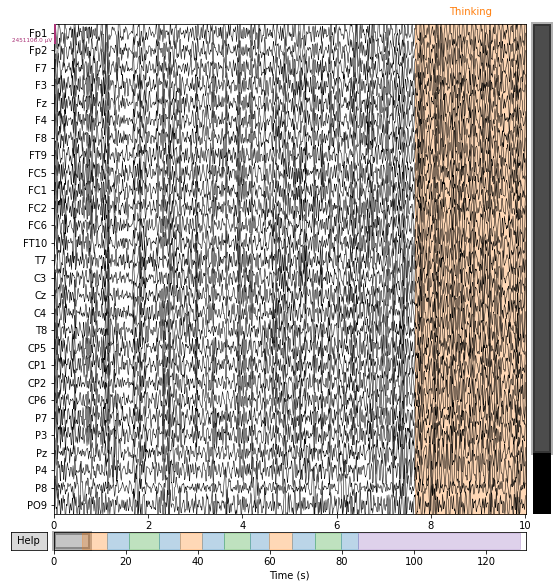

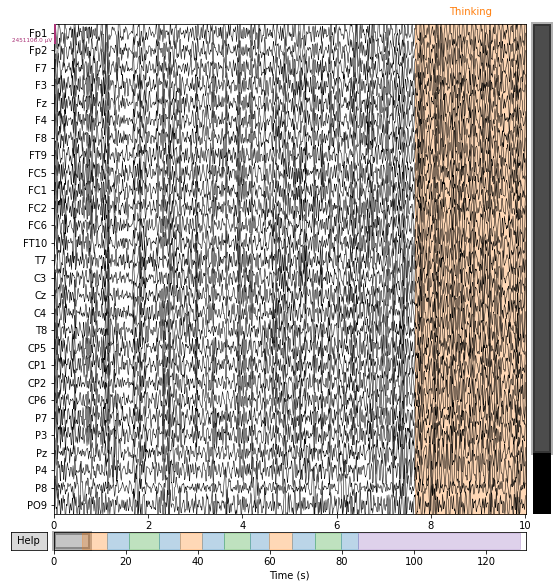

In [ ]:
raw.plot(n_channels=28, scalings="auto")

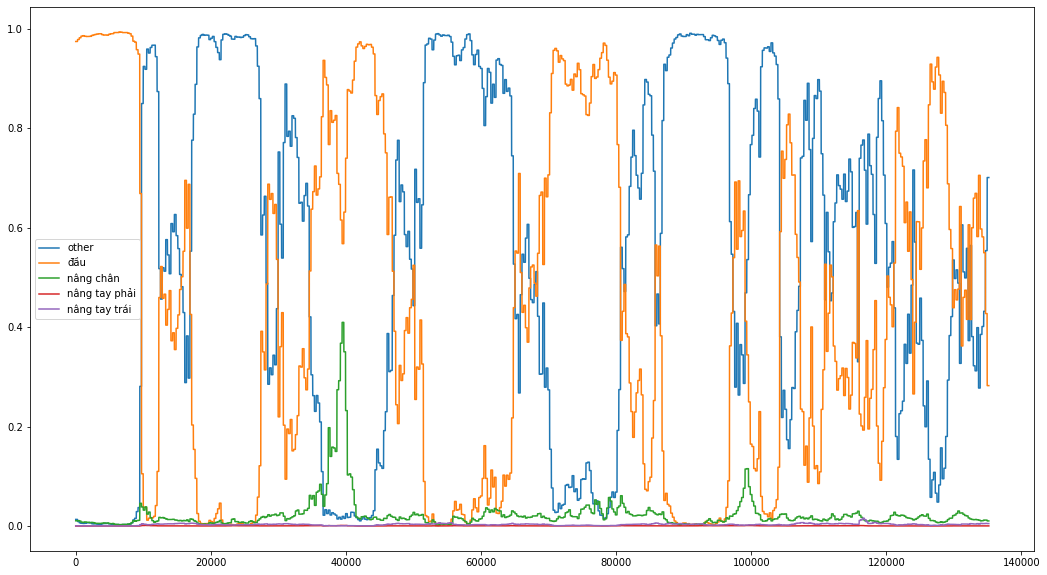

In [ ]:
# for _, r in annot.iterrows():
#     plt.axvspan(r["onset_point"], r["offset_point"])

for i in range(prob.shape[1]):
    plt.plot(np.arange(len(prob)), prob[:, i])

plt.legend(labels)

In [ ]:
spat = model[0]

with torch.no_grad():
    cov = torch.matmul(x, x.transpose(2, 1)) / (x.size(2) - 1)
    e, v = torch.linalg.eigh(cov, UPLO="U")
    e = torch.log(torch.clamp(e, min=1e-10))
    log_cov = torch.matmul(torch.matmul(v, e.diag_embed()), v.transpose(2, 1))  # [B,C,C]

    wb = log_cov[:, spat.inds[0], spat.inds[1]]  # [B,w_dim]

    # # compute log-variance
    # wb = torch.log(torch.var(x, dim=2, unbiased=True))
    # wb[torch.isneginf(wb)] = 0

    wb = spat.linear(wb)  # [B,w_out]

    w = wb[:, : -spat.n_out_channels].reshape(-1, spat.n_out_channels, spat.n_in_channels)
    b = wb[:, -spat.n_out_channels :].reshape(-1, spat.n_out_channels, 1)

    # apply soft-thresholding in [-thr,thr]
    w = torch.clamp(w - spat.thr, min=0) + torch.clamp(w + spat.thr, max=0)
    w = w.cpu().numpy()

w.shape

(224, 8, 28)

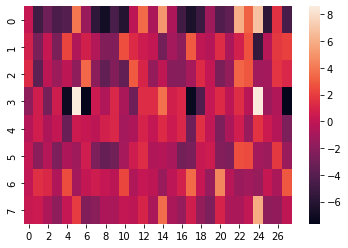

In [ ]:
sb.heatmap(w[np.where(y == 2)[0]].mean(axis=0))

In [14]:
%%time
n_classes = 7  # @param
n_remap_channels = 8  # @param
window_size = int(128 * window_duration)

epochs = 300  # @param
lr = 1e-3  # @param
weight_decay = 0.0  # @param
batch_size = 2048  # @param
smooth = 0.0  # @param
use_class_weight = True  # @param {"type": "boolean"}
use_imbalanced_sampler = True  # @param {"type": "boolean"}

results = list()
for target_subject in subjects[:15]:
    print("*" * 50)
    print(f"fitting {target_subject}...")
    print("*" * 50)

    t = time.time()

    # -----------------------------------
    # init data
    # -----------------------------------
    aligned_ds = deepcopy(ds)

    labeled_trials = [0]

    aligned_ds_info = aligned_ds.description
    for i in range(len(aligned_ds.datasets)):
        aligned_ds.datasets[i].description["split"] = "train"

    for i in aligned_ds_info[(aligned_ds_info["subject"] == target_subject) & (~aligned_ds_info["trial"].isin(labeled_trials))].index:
        aligned_ds.datasets[i].description["split"] = "valid"

    for i in aligned_ds_info[(aligned_ds_info["subject"] != target_subject) & (aligned_ds_info["label"] == "other") & (aligned_ds_info["trial"] > 0)].index:
        aligned_ds.datasets[i].description["split"] = "other"

    label_alignment(aligned_ds, target_subject=target_subject, labeled_trials=labeled_trials)
    # euclidean_alignment(aligned_ds, target_subject=target_subject, labeled_trials=None)

    splitter = aligned_ds.split("split")
    train_ds = splitter["train"]
    valid_ds = splitter["valid"]
    # test_ds = splitter["test"]

    y_train = np.concatenate([subjds.y for subjds in train_ds.datasets], axis=0)
    y_valid = np.concatenate([subjds.y for subjds in valid_ds.datasets], axis=0)
    # y_test = np.concatenate([subjds.y for subjds in test_ds.datasets], axis=0)
    print(f"train: {np.bincount(y_train)} - valid: {np.bincount(y_valid)}")
    # print(f"train: {np.bincount(y_train)} - valid: {np.bincount(y_valid)} - test: {np.bincount(y_test)}")

    # ----------------------------------
    # init model
    # ----------------------------------

    # model = ShallowFBCSPNet(
    #     in_chans=n_remap_channels, 
    #     n_classes=n_classes, 
    #     input_window_samples=window_size, 
    #     n_filters_time=32,
    #     n_filters_spat=64,
    #     filter_time_length=32,
    #     pool_time_length=64,
    #     pool_time_stride=16,
    #     final_conv_length="auto",
    #     drop_prob=0.25,
    # )
    # model = Deep4Net(
    #     in_chans=n_remap_channels,
    #     n_classes=n_classes,
    #     input_window_samples=window_size,
    #     final_conv_length="auto",
    #     pool_time_length=2,
    #     pool_time_stride=2,
    #     filter_time_length=32,
    #     filter_length_2=16,
    #     filter_length_3=8,
    #     filter_length_4=4,
    #     drop_prob=0.25,
    # )
    model = EEGNetv4(
        in_chans=n_remap_channels,
        n_classes=n_classes,
        input_window_samples=window_size,
        final_conv_length="auto",
        F1=8,
        F2=16,
        kernel_length=32,
        drop_prob=0.25,
    )
    # model = MultiResNet(
    #     n_classes=n_classes, 
    #     n_channels=n_remap_channels, 
    #     n_samples=window_size, 
    #     sfreq=128, 
    #     ft=8, 
    #     fs=16, 
    #     res_scales=3, 
    #     embedding_size=32, 
    #     drop=0.25,
    #     use_sep_conv=False,
    # )

    model = nn.Sequential(
        DynamicSpatialBlock(n_in_channels=n_channels, n_out_channels=n_remap_channels, drop=0.25),
        model,
    )

    init_weights(model)
    model = model.to(device)

    # ----------------------------------
    # fitting
    # ----------------------------------

    ckpt_dir = f"./ckpt/{model.__class__.__name__}/{target_subject}"
    os.makedirs(ckpt_dir, exist_ok=True)

    class_weight = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    print(f"class_weight: {class_weight}")

    clf = EEGClassifier(
        model,
        cropped=False,
        # criterion=nn.NLLLoss,
        criterion=FocalLoss,
        criterion__smooth=smooth,
        criterion__weight=torch.tensor(class_weight).float().to(device) if use_class_weight else None,
        criterion__gamma=2.0,
        # optimizer=optim.AdamW,
        optimizer=EAdam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        optimizer__amsgrad=True,
        train_split=predefined_split(valid_ds),
        iterator_train__shuffle=not use_imbalanced_sampler,
        iterator_train__sampler=ImbalancedDataSampler(train_ds) if use_imbalanced_sampler else None,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=os.cpu_count(),
        batch_size=batch_size,
        callbacks=[
            "balanced_accuracy", 
            "f1_weighted", 
            ("lr_scheduler", LRScheduler(policy='CosineAnnealingLR', monitor="train_loss", T_max=epochs)),
            # ("early_stopping", EarlyStopping(monitor="valid_loss", patience=15, threshold=1e-4, lower_is_better=True)),
            ("early_stopping", EarlyStopping(monitor="valid_f1_weighted", patience=15, threshold=1e-4, lower_is_better=False)),
            # ("load_state", LoadInitState()),
            # ("freezer", Freezer()),
            ("weight_initializer", Initializer("*conv*weight", partial(nn.init.kaiming_uniform_, nonlinearity="leaky_relu"))),
            # ("weight_initializer", Initializer("*conv*weight", partial(nn.init.xavier_uniform_, gain=1.0))),
            ("checkpoint", Checkpoint(monitor="valid_f1_weighted_best", dirname=ckpt_dir)),
            ("last_checkpoint", TrainEndCheckpoint(dirname=ckpt_dir)),
        ],
        device=device,
    )

    _ = clf.fit(train_ds, y=None, epochs=epochs)

    # ----------------------------------
    # evaluating
    # ----------------------------------

    clf.load_params(
        f_params=f"{ckpt_dir}/params.pt",
        f_optimizer=f"{ckpt_dir}/optimizer.pt",
        f_criterion=f"{ckpt_dir}/criterion.pt",
        f_history=f"{ckpt_dir}/history.json",
    )
    clf.module = clf.module.eval()  # ???

    x = np.concatenate([window_ds.windows.get_data() for window_ds in valid_ds.datasets], axis=0)
    y = list()
    for window_ds in valid_ds.datasets:
        y.extend(window_ds.y)
    y = np.array(y, dtype=int)
    x = torch.tensor(x).float().cuda()

    with torch.no_grad():
        y_pred = clf.predict(valid_ds)
    
    acc = metrics.balanced_accuracy_score(y_true=y, y_pred=y_pred)
    f1 = metrics.f1_score(y_true=y, y_pred=y_pred, average="weighted")
    
    print(f"acc: {acc} - f1: {f1}")
    print(metrics.classification_report(y_true=y, y_pred=y_pred))
    print(metrics.confusion_matrix(y_true=y, y_pred=y_pred))
    
    results.append((target_subject, acc, f1))
    
    del aligned_ds
    del train_ds
    del valid_ds
    # del test_ds
    del model
    del clf
    
    print("*" * 50)
    print(f"fitting {target_subject} done - time: {timedelta(seconds=time.time() - t)}s")
    print("*" * 50)

**************************************************
fitting K309...
**************************************************


subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


train: [3665 2274 2314 2309 2354 2355 2354] - valid: [726  50  46  49  46  49  45]
class_weight: [0.68700058 1.10723709 1.0880973  1.0904535  1.06960796 1.06915378
 1.06960796]


/home/txdat/code/eeg-motor-imagery/notebooks/eadam.py:99: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.2291               0.1922        1.4753                     0.1715               0.3005        1.4524     +  0.0010  10.9497
      2                     0.5000               0.4240        1.2223                     0.2733               0.2167        1.2895        0.0010  10.4995
      3                     0.5738               0.4805        0.9682                     0.3399               0.1321        1.2818        0.0010  10.7962
      4                     0.5888               0.4757        0.7523                     0.3620               0.1056        1.3031        0.0010  10.5620
      5                     0.6793               0.5693        0.5731 

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.02it/s]


train: [3665 2256 2306 2300 2355 2337 2342] - valid: [680  68  54  58  45  67  57]
class_weight: [0.68450594 1.11201874 1.08790732 1.09074534 1.06527146 1.07347637
 1.07118458]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.2295               0.2270        1.4745                     0.1817               0.4004        1.3438     +  0.0010  10.7413
      2                     0.3518               0.2902        1.3161                     0.2399               0.1940        1.3800        0.0010  10.6363
      3                     0.5486               0.4145        1.0957                     0.3049               0.1555        1.2809        0.0010  10.5739
      4                     0.5789              

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.94it/s]


train: [3665 2255 2312 2284 2345 2345 2307] - valid: [657  69  48  74  55  59  92]
class_weight: [0.68263496 1.10947102 1.08211814 1.09538404 1.06689004 1.06689004
 1.08446343]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.3226               0.2312        1.4365                     0.1629               0.0432        1.8445     +  0.0010  10.2807
      2                     0.4927               0.3705        1.1399                     0.2789               0.0729        1.5215     +  0.0010  10.3723
      3                     0.5063               0.3651        0.8658                     0.3743               0.1199        1.4071     +  0.0010  10.2762
      4                     0.5262              

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.86it/s]


train: [3665 2267 2311 2296 2336 2336 2337] - valid: [638  57  49  62  64  68  62]
class_weight: [0.68399922 1.10580377 1.08474995 1.09183673 1.0731409  1.0731409
 1.0726817 ]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.2068               0.1284        1.4157                     0.1933               0.0321        3.8446     +  0.0010  10.5902
      2                     0.2815               0.1983        1.1902                     0.2389               0.0424        3.0969     +  0.0010  10.5879
      3                     0.3477               0.2371        0.9419                     0.2935               0.0458        2.7340     +  0.0010  10.6271
      4                     0.5056               

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.85it/s]


train: [3665 2269 2298 2291 2334 2346 2335] - valid: [743  55  62  67  66  58  64]
class_weight: [0.68360943 1.10419946 1.09026483 1.09359606 1.0734484  1.06795762
 1.07298868]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.3919               0.3182        1.4251                     0.1804               0.0345        1.7348     +  0.0010  10.6884
      2                     0.6658               0.5755        1.1861                     0.3157               0.1653        1.3840     +  0.0010  10.6963
      3                     0.7899               0.7490        0.8893                     0.4069               0.3716        1.3154     +  0.0010  10.6411
      4                     0.9194              

/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
subject: 100%|█████████████████

train: [3665 2263 2297 2297 2348 2351 2345] - valid: [759  61  63  61  52  53  54]
class_weight: [0.68470084 1.10889464 1.09248088 1.09248088 1.06875152 1.06738774
 1.07011879]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1949               0.1218        1.5189                     0.1480               0.1515        1.7234     +  0.0010  11.0132
      2                     0.3387               0.2321        1.2839                     0.1762               0.0568        1.4706        0.0010  10.7644
      3                     0.5093               0.3801        1.0500                     0.2338               0.0414        1.4444        0.0010  10.7756
      4                     0.5791              

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.54it/s]


train: [3665 2279 2313 2310 2349 2358 2351] - valid: [11 45 47 48 51 46 48]
class_weight: [0.68700058 1.10480787 1.08856772 1.08998145 1.07188469 1.06779353
 1.07097284]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1813               0.1112        1.4897                     0.1438               0.0934        1.7212     +  0.0010  10.2851
      2                     0.2614               0.1748        1.3559                     0.1616               0.1123        1.3271     +  0.0010  10.3790
      3                     0.4910               0.3700        1.1415                     0.3419               0.2847        1.1949     +  0.0010  10.7193
      4                     0.5855               0.4679

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.69it/s]


train: [3665 2282 2316 2312 2359 2360 2354] - valid: [177  42  44  46  41  44  45]
class_weight: [0.6878971  1.10479529 1.08857636 1.09045971 1.06873372 1.06828087
 1.07100376]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.2706               0.2207        1.5045                     0.2075               0.1608        1.7607     +  0.0010  10.3939
      2                     0.4341               0.3300        1.2933                     0.3120               0.1251        1.4169        0.0010  10.3038
      3                     0.6985               0.5797        0.9808                     0.4729               0.2258        1.2619     +  0.0010  10.2784
      4                     0.7415              

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.79it/s]


train: [3665 2281 2325 2317 2361 2359 2351] - valid: [245  43  35  41  39  45  48]
class_weight: [0.68832586 1.10596856 1.0850384  1.08878476 1.06849398 1.06939987
 1.07303883]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1782               0.0799        1.3419                     0.1463               0.0226        2.0811     +  0.0010  10.4707
      2                     0.4227               0.3016        0.9447                     0.2247               0.0775        1.4793     +  0.0010  10.4984
      3                     0.5217               0.4027        0.7113                     0.2760               0.1032        1.2976     +  0.0010  10.5286
      4                     0.5839              

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.60it/s]


train: [3665 2275 2317 2316 2351 2352 2346] - valid: [51 49 43 42 49 52 53]
class_weight: [0.68688365 1.10656201 1.08650348 1.08697261 1.07079055 1.07033528
 1.07307271]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1837               0.1090        1.4670                     0.1330               0.0673        1.8695     +  0.0010  10.4766
      2                     0.2579               0.1723        1.2738                     0.1553               0.0594        1.5559        0.0010  10.3220
      3                     0.4933               0.3582        1.0552                     0.2063               0.1378        1.3702     +  0.0010  10.3218
      4                     0.5152               0.3725

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.70it/s]


train: [3665 2270 2311 2311 2323 2362 2359] - valid: [49 54 49 47 77 42 40]
class_weight: [0.68606509 1.10767778 1.08802621 1.08802621 1.08240576 1.06453369
 1.06588748]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1653               0.0674        1.4474                     0.1582               0.0525        2.3735     +  0.0010  10.3949
      2                     0.2851               0.1846        1.2534                     0.1990               0.0906        1.4664     +  0.0010  10.3332
      3                     0.6282               0.6259        0.9378                     0.3465               0.2490        1.2808     +  0.0010  10.3660
      4                     0.7245               0.7301

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.62it/s]


train: [3665 2256 2296 2302 2342 2346 2342] - valid: [56 68 64 56 58 58 57]
class_weight: [0.6840382  1.11125887 1.09189895 1.089053   1.0704526  1.06862745
 1.0704526 ]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1441               0.0316        1.4769                     0.1429               0.0458        2.3242     +  0.0010  10.8420
      2                     0.3573               0.2580        1.3060                     0.2123               0.1409        1.4123     +  0.0010  10.3339
      3                     0.5358               0.4101        1.0617                     0.2652               0.2260        1.3755     +  0.0010  10.2767
      4                     0.5792               0.4509

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.71it/s]


train: [3665 2276 2315 2315 2342 2350 2339] - valid: [410  48  45  43  58  54  60]
class_weight: [0.68610407 1.10482049 1.08620796 1.08620796 1.07368549 1.0700304
 1.0750626 ]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1877               0.0901        1.4548                     0.1676               0.0285        3.0303     +  0.0010  10.3566
      2                     0.3109               0.1833        1.2460                     0.2260               0.0465        1.9146     +  0.0010  10.3223
      3                     0.5673               0.4141        0.9858                     0.2736               0.0835        1.4006     +  0.0010  10.3745
      4                     0.6103               

/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
subject: 100%|█████████████████

train: [3665 2285 2308 2315 2357 2358 2353] - valid: [76 39 52 43 43 46 46]
class_weight: [0.68762424 1.10290716 1.09191632 1.08861463 1.06921632 1.06876287
 1.07103394]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.2890               0.1821        1.4193                     0.1883               0.1304        2.1475     +  0.0010  10.1382
      2                     0.3850               0.3314        1.1271                     0.2134               0.1693        1.7181     +  0.0010  10.1008
      3                     0.5009               0.4882        0.8909                     0.2049               0.1742        1.9330     +  0.0010  10.1530
      4                     0.5988               0.5929

subject: 100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.69it/s]


train: [3665 2262 2306 2300 2342 2345 2338] - valid: [197  62  54  58  58  59  61]
class_weight: [0.68438901 1.10887963 1.08772147 1.09055901 1.07100159 1.06963143
 1.07283392]
  epoch    train_balanced_accuracy    train_f1_weighted    train_loss    valid_balanced_accuracy    valid_f1_weighted    valid_loss    cp      lr      dur
-------  -------------------------  -------------------  ------------  -------------------------  -------------------  ------------  ----  ------  -------
      1                     0.1834               0.0762        1.4325                     0.1887               0.0544        2.9940     +  0.0010  10.5890
      2                     0.2816               0.1421        1.2176                     0.2253               0.0654        1.7232     +  0.0010  10.4953
      3                     0.6685               0.5873        0.9454                     0.4759               0.3182        1.1797     +  0.0010  10.4396
      4                     0.6048              

In [ ]:
# K325  0.5990               0.5260        0.7989
# K325  0.6334               0.5675        0.5153

In [ ]:
# 'K309',       100                     1.0000               1.0000        0.0040                     0.7635               0.7594        0.4648     +  0.0008  3.8243
# 'K311',        46                     1.0000               1.0000        0.0124                     0.7373               0.7208        0.4413     +  0.0009  3.8167
# 'K313',        12                     1.0000               1.0000        0.0721                     0.7410               0.6738        0.7258     +  0.0010  3.8148
# 'K315',        63                     1.0000               1.0000        0.0074                     0.7247               0.7268        0.3725     +  0.0009  3.8023
# 'K322',        58                     1.0000               1.0000        0.0068                     0.7230               0.7253        0.4092     +  0.0009  3.7935
# 'K323',        63                     1.0000               1.0000        0.0055                     0.7675               0.7010        0.4739        0.0009  3.8448
# 'K324',        53                     1.0000               1.0000        0.0108                     0.7157               0.6946        0.3919     +  0.0009  3.8118
# 'K328',        53                     1.0000               1.0000        0.0103                     0.7404               0.6982        0.5364     +  0.0009  3.7987
# 'K358',        89                     1.0000               1.0000        0.0055                     0.6787               0.6629        0.3765     +  0.0008  3.8025
# 'K361',        61                     1.0000               1.0000        0.0096                     0.6373               0.6415        0.5640     +  0.0009  3.7849
# 'K372',        51                     1.0000               1.0000        0.0088                     0.6363               0.6378        0.4514     +  0.0009  3.8030

In [ ]:
clf.load_params(
    f_params=f"{ckpt_dir}/params.pt",
    f_optimizer=f"{ckpt_dir}/optimizer.pt",
    f_criterion=f"{ckpt_dir}/criterion.pt",
    f_history=f"{ckpt_dir}/history.json",
)

In [ ]:
y_valid = np.concatenate([subjds.y for subjds in valid_ds.datasets], axis=0)
# y_test = np.concatenate([subjds.y for subjds in test_ds.datasets], axis=0)
pred_valid = clf.predict(valid_ds)
# pred_test = clf.predict(test_ds)

print("=" * 80)
print("metrics")
print("=" * 80)
print("validation")
print(f"accuracy:\t{metrics.balanced_accuracy_score(y_valid, pred_valid)}")
print(f"      f1:\t{metrics.f1_score(y_valid, pred_valid, average='weighted')}")
print(f"   kappa:\t{metrics.cohen_kappa_score(y_valid, pred_valid)}")
# print("testing")
# print(f"accuracy:\t{metrics.balanced_accuracy_score(y_test, pred_test)}")
# print(f"      f1:\t{metrics.f1_score(y_test, pred_test, average='weighted')}")
# print(f"   kappa:\t{metrics.cohen_kappa_score(y_test, pred_test)}")
print()

print("=" * 80)
print("confusion matrix")
print("=" * 80)
print("validation")
print(metrics.confusion_matrix(y_valid, pred_valid))
# print("testing")
# print(metrics.confusion_matrix(y_test, pred_test))
print()

print("=" * 80)
print("classification report")
print("=" * 80)
print("validation")
print(metrics.classification_report(y_valid, pred_valid))
# print("testing")
# print(metrics.classification_report(y_test, pred_test))

metrics
validation
accuracy:	0.3312422470317207
      f1:	0.2825502242946014
   kappa:	0.19684390272625574

confusion matrix
validation
[[30  6  0  0  0  2]
 [14 18  4  2  3  3]
 [ 1 24  2  6  4  3]
 [ 2 27  2  2  3  4]
 [ 0 28  1  0  0 12]
 [ 4 10  0  0  0 31]]

classification report
validation
              precision    recall  f1-score   support

           0       0.59      0.79      0.67        38
           1       0.16      0.41      0.23        44
           2       0.22      0.05      0.08        40
           3       0.20      0.05      0.08        40
           4       0.00      0.00      0.00        41
           5       0.56      0.69      0.62        45

    accuracy                           0.33       248
   macro avg       0.29      0.33      0.28       248
weighted avg       0.29      0.33      0.28       248



In [ ]:
pred_valid_prob = np.exp(clf.predict_proba(valid_ds))
pred_valid_prob.shape

(272, 6)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

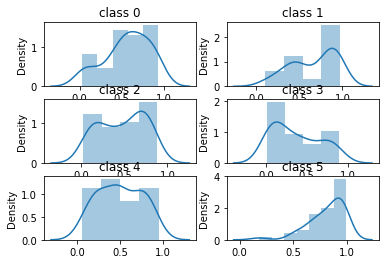

In [ ]:
fig, axes = plt.subplots(3, 2)
for i, y in enumerate(range(6)):
    axes[i // 2, i % 2].set_title(f"class {y}")
    sb.distplot(pred_valid_prob[np.where(y_valid == y)[0], y], hist=True, ax=axes[i // 2, i % 2])

In [ ]:
valid_ds.datasets[0].windows.event_id

{'gật đầu_Thinking': 0,
 'lắc đầu_Thinking': 1,
 'nâng chân phải_Thinking': 2,
 'nâng chân trái_Thinking': 3,
 'nâng tay phải_Thinking': 4,
 'nâng tay trái_Thinking': 5}

In [ ]:
x = ds.datasets[0].windows.get_data()
x.shape